# Introduction to Domain Adaptation and Optimal Transport

## Domain Adaptation: Definition and problem

**Domain Adaptation** is a major problem in Machine Learning, where the goal is to adapt a model trained on a source domain to a target domain, usually presenting differences in distribution. In most cases, models are trained on a specific dataset and may face poor performance when applied to a new dataset with different characteristics. Domain Adaptation aims to solve this problem by reducing the gap between these two domains and thus improving the model's performance on the target domain.

The main challenge of Domain Adaptation is to deal with the differences in distribution between the source and target domains. These differences may be due to variations in the examples' features, selection biases, or differences in observation conditions. When these differences are significant, models trained on the source domain may have poor performance on the target domain, making it difficult to use them in real-world applications.

## Optimal Transport: a solution for Domain Adaptation

In the paper "Optimal Transport for Domain Adaptation" by Aude Genevay, Gabriel Peyré, and Marco Cuturi, the authors propose using **Optimal Transport** theory to solve the Domain Adaptation problem. Optimal Transport is a mathematical method that determines the optimal way to transfer a probability distribution to another, minimizing a given transport cost.

The authors show that Optimal Transport can be used to align the source and target domain distributions by determining a transformation that minimizes the distance between these two domains. This transformation can then be applied to the source domain examples to adapt them to the target domain, thereby improving the model's performance.

## Objective of the Notebook

In this notebook, we will first recontextualize the Domain Adaptation problem and present a concrete example to illustrate its impact on Machine Learning models. Then, we will use the `ott-Jax` package to implement an Optimal Transport-based solution, building on the research paper mentioned earlier. We will show that Optimal Transport effectively solves the fitting issues induced by Domain Adaptation and thus improves the model's performance on the target domain. We will compare this package with the POT package to check the convergence of the OT method and the computational cost of each packages. 

## Mathematical Development

In their paper, the authors suggest that the domain adaptation problem can be seen as a graph matching problem. The use of optimal transport for this problem is based on the hypothesis that the domain drift is due to a transformation $T : \mathcal{X}^{source} \rightarrow \mathcal{X}^{target}$. This transformation can be interpreted as the push forward or transport map of $\mu$ to $\nu$, i.e., $T\#\mu = \nu$.

We can then derive a procedure to solve the adaptation problem:
1. Estimate $\mu$ and $\nu$ with the datasets
2. Estimate the transport map $T$ as defined above
3. Train a classifier on the transported source sample $T(\mathcal{X}^{source})$

As finding T from all possible transformations is intractable, we will introduce a cost function and solve the Monge or Kantorovitch problem. The Monge problem seeks to find a deterministic transport map that minimizes the cost function, while the Kantorovitch problem seeks to find a probabilistic transport plan.

The Kantorovitch formulation is more tractable and can be expressed as a linear optimization problem:

$$
\Pi^* = \arg\min_{\Pi \in \mathcal{U}(\mu, \nu)} \langle \Pi, C \rangle_F
$$

where $\Pi^*$ is the optimal transport plan, $\mathcal{U}(\mu, \nu)$ is the set of transport plans with marginals $\mu$ and $\nu$, $C$ is the cost matrix, and $\langle \cdot, \cdot \rangle$

## Tool problem of binary classification under domain drift 

Let's define a source sample $D_n = (X,Y) = ((X_{i})^{n}_{i=1} , (Y_{i})^{n}_{i=1} )$ with $X \in \mathbb{X} $ and $Y \propto g(X,\theta) \in \{-1,1\} = \mathbb{Y} $.The idea is to find $g(X,\theta)$ such that $g(X,\theta^*)$ best reproduces $Y$, the best possible classifier $\forall (X,Y) \in (\mathbb{X} , \mathbb{Y})$.

We define $X \sim N(\mu,\sigma)$ as $\mu = \mathbb{1}_{\{Y_i = -1\}} \mu_{-1} + \mathbb{1}_{\{Y_i = 1\}} \mu_1$ where $\mu_{-1} \neq \mu_{1}$. More they are different, more the classifier estimate is close than the bayesian classifier (the perfect classifier). $\sigma$ is define as the same process : $\sigma = \mathbb{1}_{\{Y_i = -1\}} \sigma_{-1} + \mathbb{1}_{\{Y_i = 1\}} \sigma_1$ where $\sigma_{-1} \neq \sigma_{1}$, this specification will make the optimal transport more flexible but more complicate too. 


We make an artificial domain drift with changing the values of $\mu$ and $\sigma$ for a new dataset ($X'$). The idea is to check the robustess of our first classifier on the new sample which using different distribution, thought, to have the most general function of $g(\cdot,\theta)$ to with $X \sim N(\mu,\sigma)$, $X' \sim N(\mu',\sigma')$ and $\mu \neq \mu'$, $\sigma \neq \sigma'$.

The notation would be : $(X_i,Y_i)^{n_s}_{i=1}$ for the source sample and $(X'_i,Y'_i)^{n_t}_{i=1}$ the target sample with the domain drift. 

How to solve this problem ? 

- Firstly, we will apply a SVM classifier on this problem to check the performance and to show the cost on the classifier performance by the domain drift.
- Secondly, we will use the Optimal transport of OTT-Jax and POT packages to set our two data set to the same distribution and we will apply the classifier on. 



In [ ]:
import sys

if "google.colab" in sys.modules:
    !pip install ott-jax
    !pip install pot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Dependies and packages

In [ ]:
from functools import partial

import jax
import jax.numpy as jnp
import numpy as np
import ot as pot
import ot.plot
from jax import jit
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import matplotlib.pylab as plt

import ott.tools
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

## Construction of the tool problem with jax 

This function could be improved but it's a equivalent of ot.datasets.make_data_classif() from POT with the domain drit implication. 

In [ ]:
def make_classification_domain_drift(
    n,
    noise_level,
    drift_intensity_mean,
    drift_intensity_var,
    numpy_output,
    rng=jax.random.PRNGKey(42),
):
    """
    Creates two two-dimensional classification datasets, one being a shift
    (shift) of the first. The second dataset is modified to introduce a domain drift.
    domain drift.

    Args:
    - n (int): The number of data points in each dataset.
    - noise_level (float): The standard deviation of the normal distribution from which noise is added.
    - drift_intensity_mean (float): The mean of the normal distribution from which the intensity
                                    drift intensity is drawn from.
    - drift_intensity_var (float): The variance of the normal distribution from which the drift intensity
                                   drift intensity is drawn.
    - numpy_output (bool): A boolean indicating whether the returned data should be converted to numpy
                           arrays or not.
    - rng (jax.random.PRNGKey, optional): A random number generator key. The default value is
                                          default is jax.random.PRNGKey(42).

    Returns:
    - x_s (jax.interpreters.xla.DeviceArray): An array of form (n, 2) containing the data points
                                              for the source dataset.
    - y_s (jax.interpreters.xla.DeviceArray): An array of form (n,) containing the class labels
                                              for the source dataset.
    - x_t (jax.interpreters.xla.DeviceArray): An array of form (n, 2) containing the data points
                                              for the target dataset.
    - y_t (jax.interpreters.xla.DeviceArray): An array of form (n,) containing the class labels
                                              for the target dataset.
    """

    @partial(jit, static_argnums=(1, 2, 3, 4, 5))
    def create_points(
        rng: jax.random.PRNGKeyArray,
        n: int,
        d: int,
        theta: float,
        noise_level: float,
        scale: float,
    ):
        rngs = jax.random.split(rng, 3)
        x1 = jax.random.normal(rngs[0], (n // 2, d)) + jnp.array([1.0, 0.0])
        x2 = jax.random.normal(rngs[1], (n // 2, d)) + jnp.array([-1.0, 0.0])
        x = (
            jnp.concatenate([x1, x2], axis=0)
            + jax.random.normal(rngs[2], (n, d)) * noise_level
        )
        y = jnp.concatenate([jnp.zeros(n // 2), jnp.ones(n // 2)], axis=0)
        x = rotate(x, theta) * scale
        return x, y

    @jit
    def rotate(x, theta):
        rotation_matrix = jnp.array(
            [
                [jnp.cos(theta), -jnp.sin(theta)],
                [jnp.sin(theta), jnp.cos(theta)],
            ]
        )
        return jnp.dot(x, rotation_matrix.T)

    d = 2
    theta = 2 * np.pi / 20

    rngs = jax.random.split(rng, 3)
    rng = rngs[0]

    x_s, y_s = create_points(
        rngs[1], n=n, d=d, theta=0, noise_level=noise_level, scale=1.0
    )
    x_t, y_t = create_points(
        rngs[2], n=n, d=d, theta=theta, noise_level=noise_level, scale=1.0
    )

    x_t = x_t.at[y_t == 1].mul(drift_intensity_var)
    x_t = x_t + drift_intensity_mean

    if numpy_output:
        x_s = jax.device_get(x_s)
        y_s = jax.device_get(y_s)
        x_t = jax.device_get(x_t)
        y_t = jax.device_get(y_t)

    return x_s, y_s, x_t, y_t

Here we found the parameters setting, it could be moved to make this problem more complexe and to chalenge the OT solution 

In [ ]:
x_s, y_s, x_t, y_t = make_classification_domain_drift(
    n=100,
    noise_level=0.05,
    drift_intensity_mean=3,
    drift_intensity_var=1.5,
    numpy_output=False,
)

# if we want the same output in np.array()
x_s_np, y_s_np, x_t_np, y_t_np = make_classification_domain_drift(
    n=100,
    noise_level=0.05,
    drift_intensity_mean=3,
    drift_intensity_var=1.5,
    numpy_output=True,
)

We can visualize the data set in a graph. The goal of this problem is to find the best classifier to separate green and yellow data point. 

Text(0.5, 1.0, 'Our Dataset for classification with domain drift')

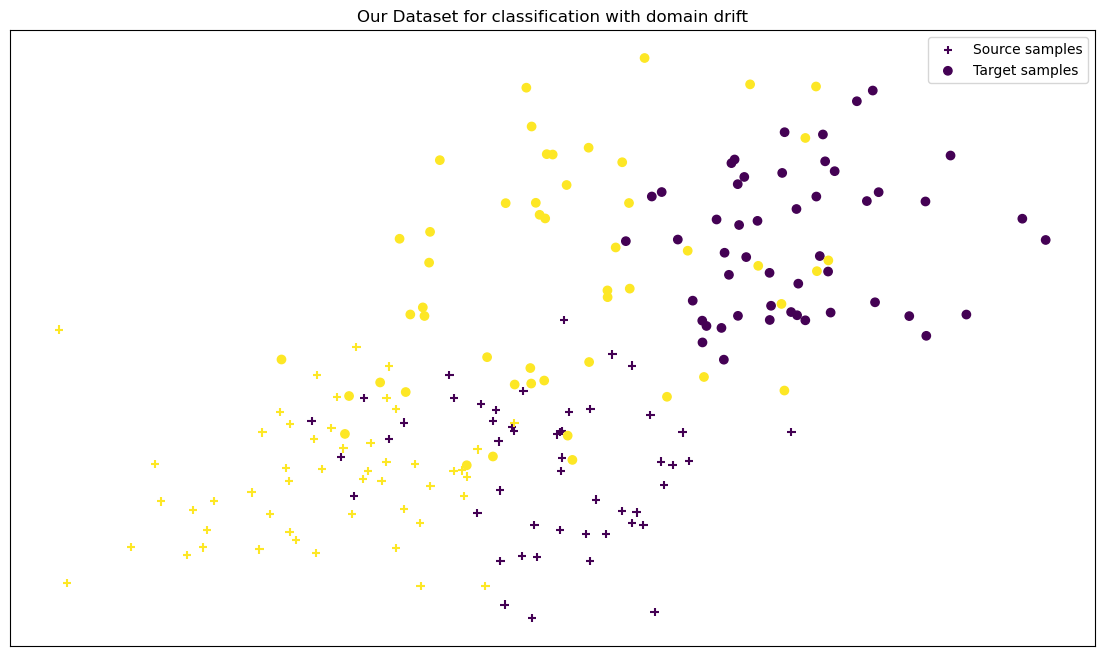

In [ ]:
plt.figure(1, figsize=(14, 8))
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker="+", label="Source samples")
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker="o", label="Target samples")
plt.xticks([])
plt.yticks([])
plt.legend(loc=0)
plt.title(label="Our Dataset for classification with domain drift")

If we do a simple SVM on the source sample and we want to predict the target sample, we fall on the domain adptation ! Let's see that, we will use the accuracy metric ! 

In [ ]:
# Make the classifier :
def SVM_classifier(X, y, target_x, target_y):
    """
    Builds an SVM model to classify the X and y data. Then, the model is used to predict
    the class labels of target_x and estimates the prediction accuracy. Finally, the function returns
    the trained SVM model, the coordinates of the decision plane built by the model, the accuracy and the
    predictions for the target data.

    Args:
    - X (np.ndarray): An array of form (n, d) containing the data points for the training set.
    - y (np.ndarray): An array of form (n,) containing the class labels for the training set.
    - target_x (np.ndarray): A shape array (m, d) containing the data points for the test set.
    - target_y (np.ndarray): A shape array (m,) containing the class labels for the test set.

    Returns:
    - svm_model (sklearn.svm._classes.SVC): A trained SVM model.
    - x_points (np.ndarray): An array of form (50,) containing the x-coordinates for the decision plane constructed
                             by the model.
    - y_points (np.ndarray): A shape array (50,) containing the y coordinates for the decision plan constructed
                             by the model.
    - accuracy (float): The prediction accuracy of the model on the test set.
    """

    svc_model = SVC(kernel="linear", random_state=42)
    svc_model.fit(X, y)

    # Constructing a hyperplane using a formula.
    w = svc_model.coef_[0]  # w consists of 2 elements
    b = svc_model.intercept_[0]  # b consists of 1 element
    x_points = np.linspace(-5, 5)
    y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting
    prediction_xt = svc_model.predict(target_x)
    accuracy = accuracy_score(target_y, prediction_xt)
    print("Accuracy:", accuracy)

    return svc_model, x_points, y_points, accuracy

In [ ]:
def plotter(
    x_s, plot_label_s, svm_model_StoT, x_points_StoT, y_points_StoT, acc_StoT
):
    """
    Plots a graph of the data points of the source and target sets, with the decision plan
    constructed by the SVM model. The prediction accuracy is also displayed.

    Args:
    - x_s (np.ndarray): An array of form (n, 2) containing the data points for the source set.
    - plot_label_s (str): A string containing the label to use for the source set in the legend.
    - x_points_StoT (np.ndarray): An array of form (50,) containing the x-coordinates for the decision plane constructed
                                  by the SVM model for the source to target set.
    - y_points_StoT (np.ndarray): An array of form (50,) containing the y coordinates for the decision plane constructed
                                  by the SVM model for the source-to-target set.
    - acc_StoT (float): The prediction accuracy of the model on the target set.
    """
    plt.figure(1, figsize=(14, 8))
    plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker="+", label=plot_label_s)
    plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker="o", label="Target samples")
    plt.plot(x_points_StoT, y_points_StoT, c="r")
    x_min = min(x_s[:, 0].min(), x_t[:, 0].min()) - 1
    x_max = max(x_s[:, 0].max(), x_t[:, 0].max()) + 1
    y_min = min(x_s[:, 1].min(), x_t[:, 1].min()) - 1
    y_max = max(x_s[:, 1].max(), x_t[:, 1].max()) + 1
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc=0)
    plt.title(
        label=f"Classifier fitted on source data to Target data. Accuracy : {np.round(acc_StoT,2)*100} %"
    )
    plt.show()

The Oracle SVM (ie the SVM trained on the target, asssuming we have their labels) is :

Accuracy: 0.85


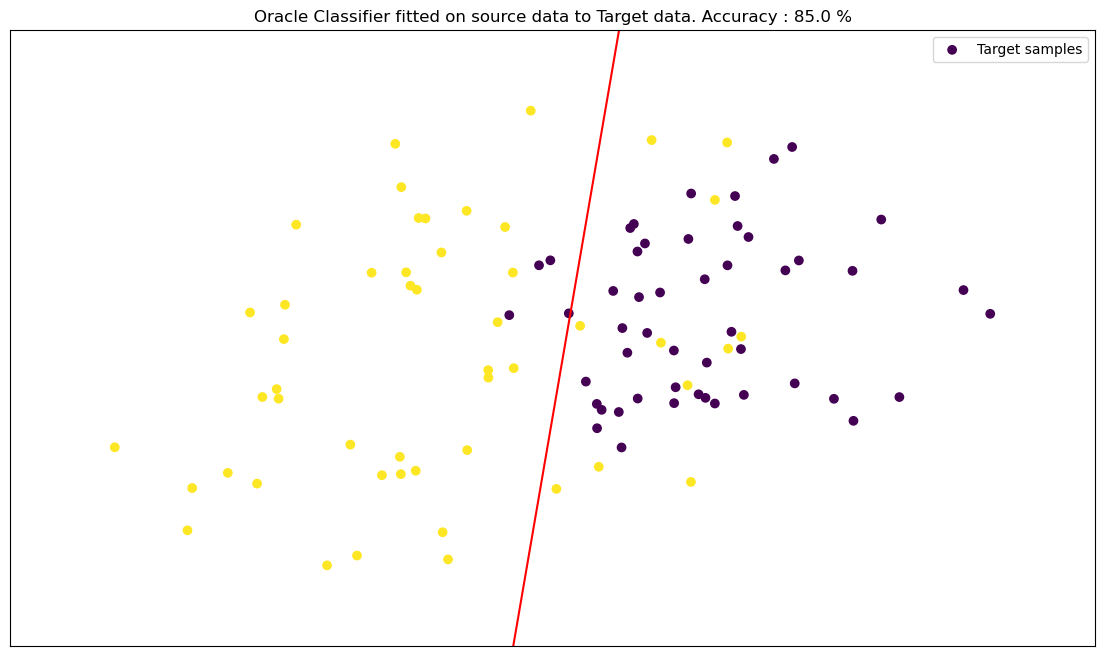

In [ ]:
(
    svm_model_StoT_oracle,
    x_points_StoT_oracle,
    y_points_StoT_oracle,
    acc_StoT_oracle,
) = SVM_classifier(X=x_t, y=y_t, target_x=x_t, target_y=y_t)

plt.figure(1, figsize=(14, 8))
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker="o", label="Target samples")
plt.plot(x_points_StoT_oracle, y_points_StoT_oracle, c="r")
x_min = x_t[:, 0].min() - 1
x_max = x_t[:, 0].max() + 1
y_min = x_t[:, 1].min() - 1
y_max = x_t[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks([])
plt.yticks([])
plt.legend(loc=0)
plt.title(
    label=f"Oracle Classifier fitted on source data to Target data. Accuracy : {acc_StoT_oracle*100} %"
)
plt.show()

We train an SVM on the source samples and use it to classify target samples.

In [ ]:
svm_model_StoT, x_points_StoT, y_points_StoT, acc_StoT = SVM_classifier(
    X=x_s, y=y_s, target_x=x_t, target_y=y_t
)

Accuracy: 0.56


We can graph the SVM line : 

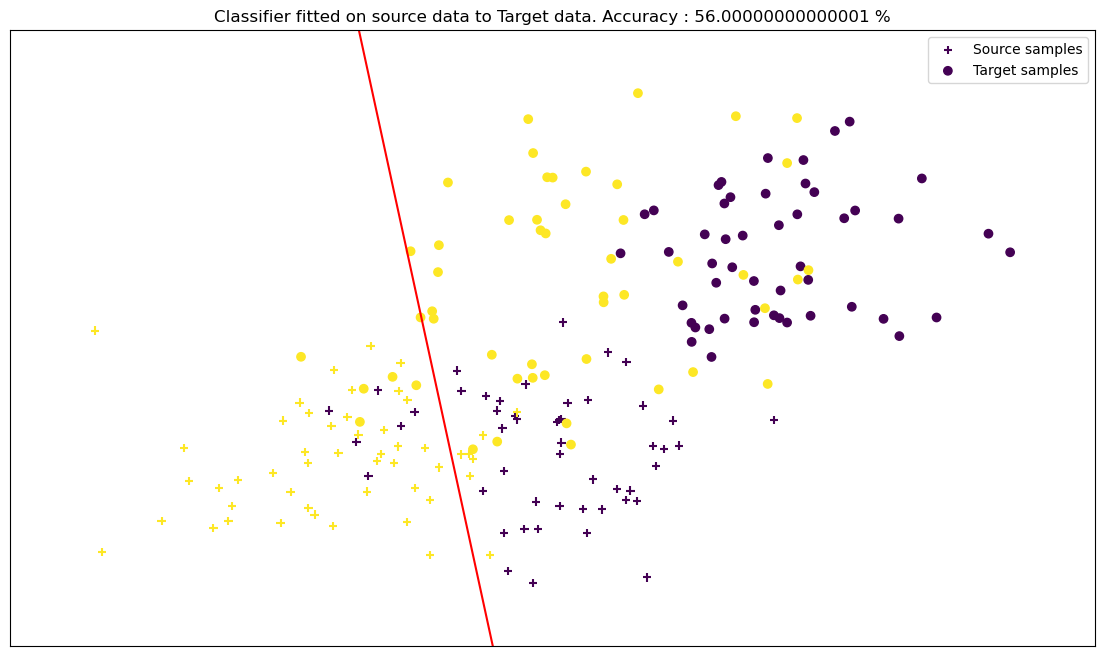

In [ ]:
plotter(
    x_s,
    "Source samples",
    svm_model_StoT,
    x_points_StoT,
    y_points_StoT,
    acc_StoT,
)

We can see that the domain drift change completly the distribution of X and Y for the target data. We cannot use the source data to predict the target data. So that's why we will try to transport the source sample to the target sample in distribution using the optimal transport and fit the model with the transported sample. 

We can try to fit the classifier with all the data points, we agg the source and the target sample, let's see : 

In [ ]:
x_all = np.concatenate((x_s, x_t), axis=0)
y_all = np.concatenate((y_s, y_t), axis=0)

svm_model_all, x_points_all, y_points_all, acc_all = SVM_classifier(
    X=x_all, y=y_all, target_x=x_t, target_y=y_t
)

Accuracy: 0.78


Text(0.5, 1.0, 'Classifier fitted on all data. Accuracy : 78.0 %')

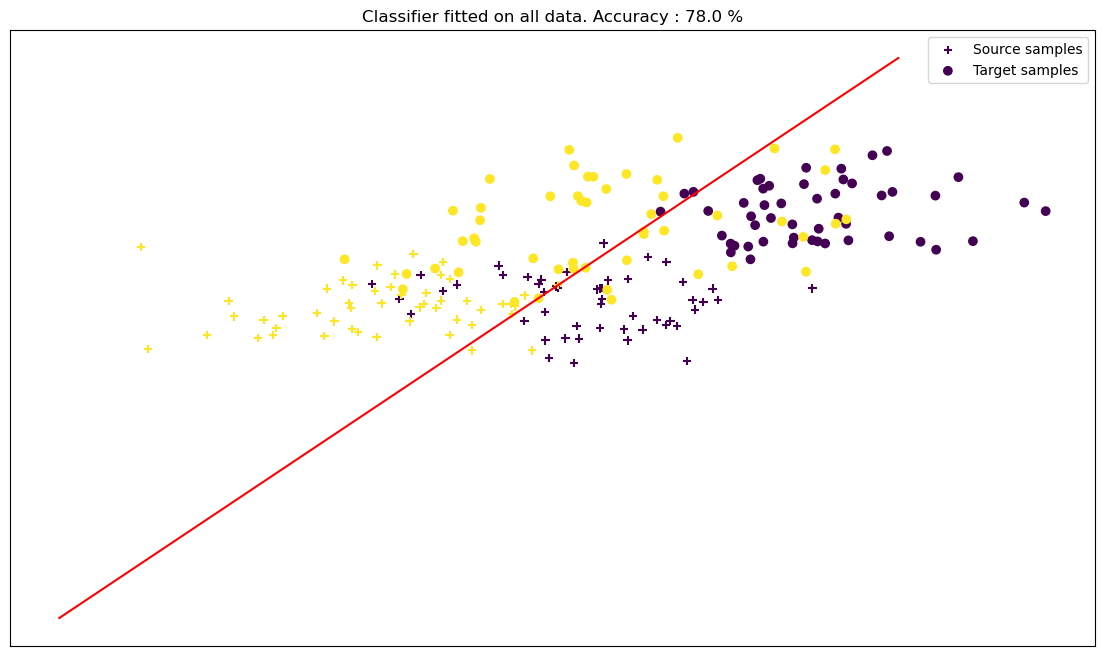

In [ ]:
plt.figure(1, figsize=(14, 8))
plt.scatter(x_s[:, 0], x_s[:, 1], c=y_s, marker="+", label="Source samples")
plt.scatter(x_t[:, 0], x_t[:, 1], c=y_t, marker="o", label="Target samples")
plt.plot(x_points_all, y_points_all, c="r")
plt.xticks([])
plt.yticks([])
plt.legend(loc=0)
plt.title(label=f"Classifier fitted on all data. Accuracy : {acc_all*100} %")

Now, we will try to transport our source data to the target one, for that, we will try different method of Optimal transport. We can simply understand that the number of points in the source and the target sample will have a computation cost. 

### Optimal transport ! 

With OTT-JAX 

In [ ]:
# We define our geometry and our problem, which we then solve
geom = pointcloud.PointCloud(x_s, x_t)
ot_prob = linear_problem.LinearProblem(geom)


solver = sinkhorn.Sinkhorn()
ot = solver(ot_prob)
dual_potentials = ot.to_dual_potentials()
transp_x_s = dual_potentials.transport(x_s)

# The out object contains many things, among which the regularized OT cost
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.reg_ot_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix),
)

 Sinkhorn has converged:  True 
 Error upon last iteration:  0.0007396899 
 Sinkhorn required  4  iterations to converge. 
 Entropy regularized OT cost:  18.57837 
 OT cost (without entropy):  17.094418


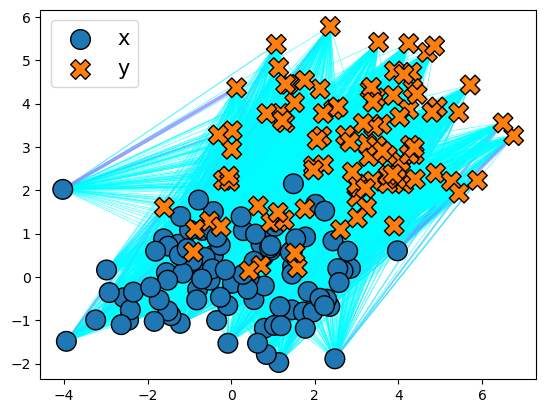

In [ ]:
plott = ott.tools.plot.Plot()
_ = plott(ot)  # takes quite some time ! ~3mins in colab

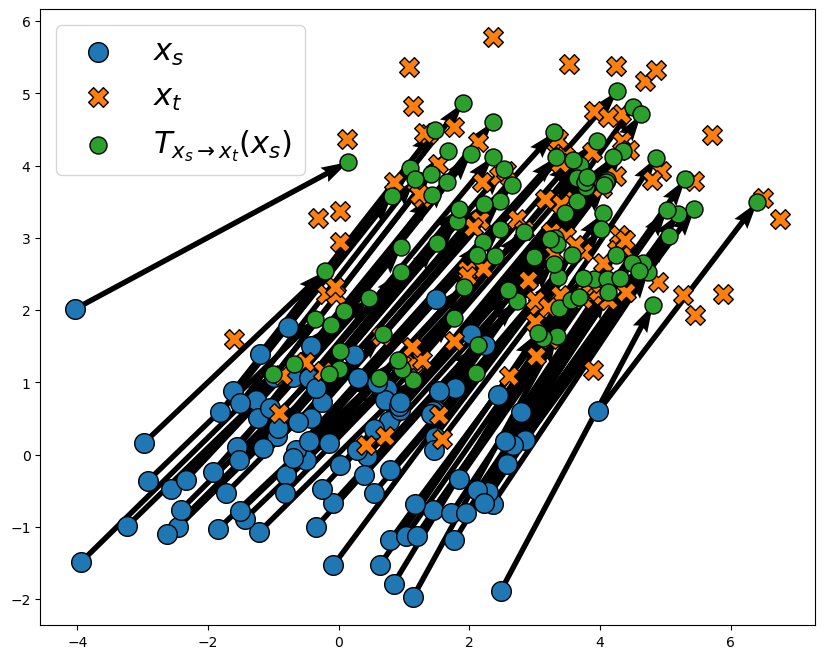

In [ ]:
# Plotting utility
def plot_map(x, y, z, forward: bool = True):
    plt.figure(figsize=(10, 8))
    marker_t = "o" if forward else "X"
    label = (
        r"$T_{x_s\rightarrow x_t}(x_s)$"
        if forward
        else r"$T_{x_t\rightarrow x_s}(x_s)$"
    )
    w = x if forward else y
    plt.quiver(
        *w.T,
        *(z - w).T,
        color="k",
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.007,
    )
    plt.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x_s$")
    plt.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$x_t$")
    plt.scatter(*z.T, s=150, edgecolors="k", marker=marker_t, label=label)
    plt.legend(fontsize=22)


plot_map(x_s, x_t, transp_x_s)

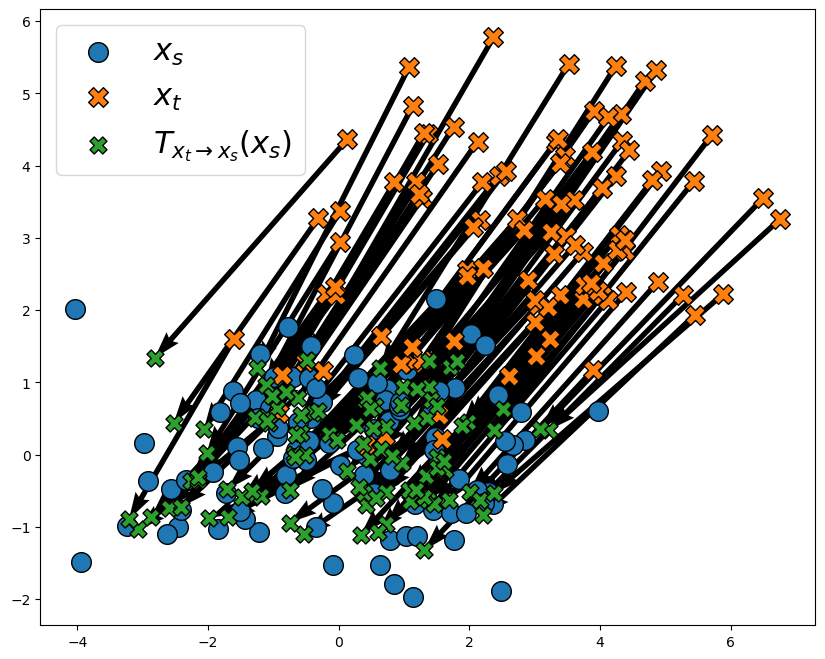

In [ ]:
plot_map(x_s, x_t, dual_potentials.transport(x_t, forward=False), forward=False)

In [ ]:
# We fit a new svm model on the transported data
(
    svm_model_StoT_ott,
    x_points_StoT_ott,
    y_points_StoT_ott,
    acc_StoT_ott,
) = SVM_classifier(X=transp_x_s, y=y_s, target_x=x_t, target_y=y_t)

Accuracy: 0.86


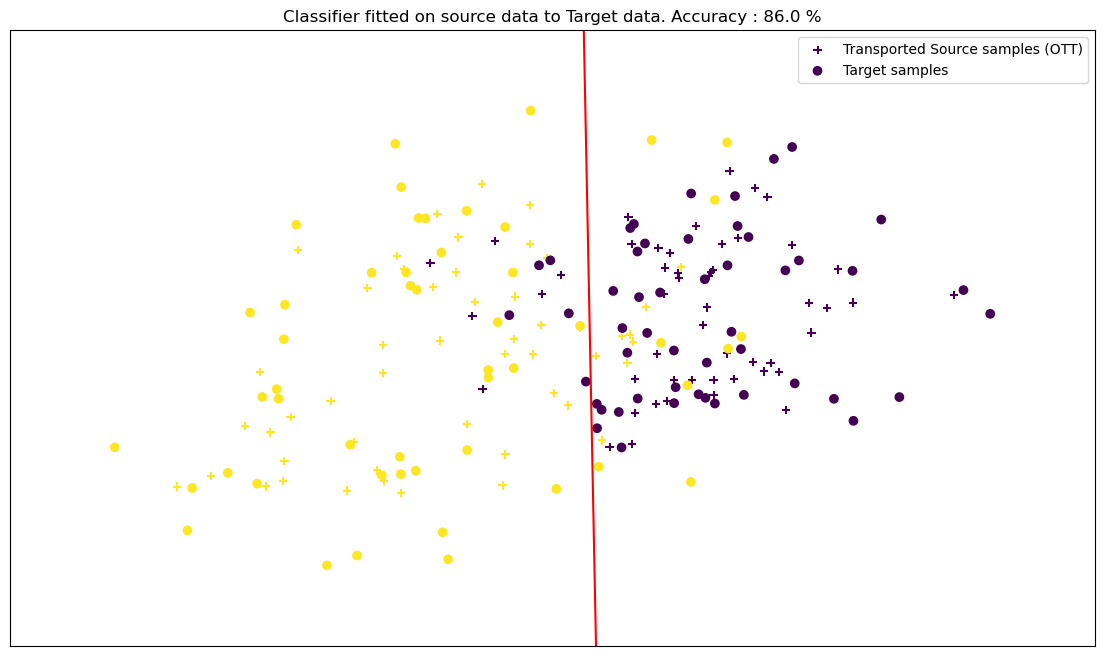

In [ ]:
plotter(
    transp_x_s,
    "Transported Source samples (OTT)",
    svm_model_StoT_ott,
    x_points_StoT_ott,
    y_points_StoT_ott,
    acc_StoT_ott,
)

With domain adapatation, the accuracy of the SVM is much better ! It now has 86% accuracy vs 56% previously.

Now let's do the same with the POT package

In [ ]:
# MappingTransport with linear kernel
ot_mapping_linear = pot.da.MappingTransport(
    kernel="linear", mu=1e0, eta=1e-8, bias=True, max_iter=100, verbose=True
)

ot_mapping_linear.fit(Xs=x_s_np, Xt=x_t_np)

# for original source samples, transform applies barycentric mapping
transp_Xs_linear = ot_mapping_linear.transform(Xs=x_s_np)


# MappingTransport with gaussian kernel
ot_mapping_gaussian = pot.da.MappingTransport(
    kernel="gaussian",
    eta=1e-5,
    mu=1e-1,
    bias=True,
    sigma=1,
    max_iter=100,
    verbose=True,
)
ot_mapping_gaussian.fit(Xs=x_s_np, Xt=x_t_np)

# for original source samples, transform applies barycentric mapping
transp_Xs_gaussian = ot_mapping_gaussian.transform(Xs=x_s_np)

It.  |Loss        |Delta loss
--------------------------------
    0|1.656932e+03|0.000000e+00
    1|1.644805e+03|-7.318675e-03
    2|1.644282e+03|-3.181539e-04
    3|1.644052e+03|-1.399231e-04
    4|1.643922e+03|-7.878123e-05
    5|1.643843e+03|-4.789134e-05
    6|1.643785e+03|-3.562058e-05
    7|1.643741e+03|-2.675569e-05
    8|1.643708e+03|-1.979708e-05
    9|1.643686e+03|-1.373094e-05
   10|1.643674e+03|-7.160307e-06
It.  |Loss        |Delta loss
--------------------------------
    0|1.808420e+02|0.000000e+00
    1|2.723626e+02|5.060806e-01
    2|1.419921e+03|4.213349e+00
    3|7.292182e+03|4.135625e+00
    4|1.037221e+04|4.223738e-01
    5|1.070781e+04|3.235532e-02
    6|1.082805e+04|1.122944e-02
    7|1.082870e+04|6.012104e-05
    8|1.086683e+04|3.520965e-03
    9|1.082858e+04|-3.519504e-03
   10|1.086027e+04|2.926247e-03
   11|1.084667e+04|-1.251612e-03
   12|1.084477e+04|-1.753916e-04
   13|1.084802e+04|2.992333e-04
   14|1.087694e+04|2.666510e-03
   15|1.082746e+04|-4.549634e

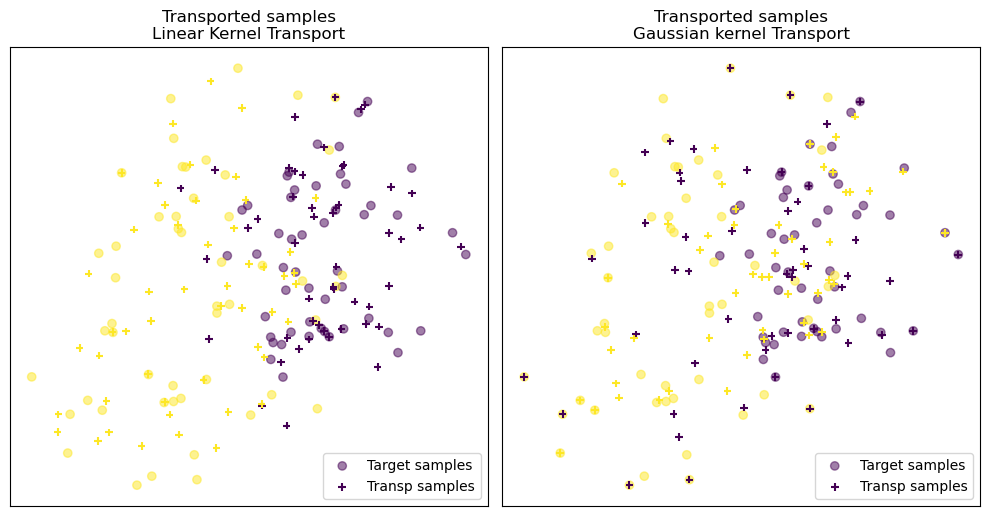

In [ ]:
plt.figure(1, figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.scatter(
    x_t[:, 0], x_t[:, 1], c=y_t, marker="o", label="Target samples", alpha=0.5
)
plt.scatter(
    transp_Xs_linear[:, 0],
    transp_Xs_linear[:, 1],
    c=y_s,
    marker="+",
    label="Transp samples",
    s=30,
)
plt.title("Transported samples\nLinear Kernel Transport")
plt.legend(loc=0)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.scatter(
    x_t[:, 0], x_t[:, 1], c=y_t, marker="o", label="Target samples", alpha=0.5
)
plt.scatter(
    transp_Xs_gaussian[:, 0],
    transp_Xs_gaussian[:, 1],
    c=y_s,
    marker="+",
    label="Transp samples",
    s=30,
)
plt.title("Transported samples\nGaussian kernel Transport")
plt.legend(loc=0)
plt.xticks([])
plt.yticks([])

plt.show()

Accuracy: 0.84


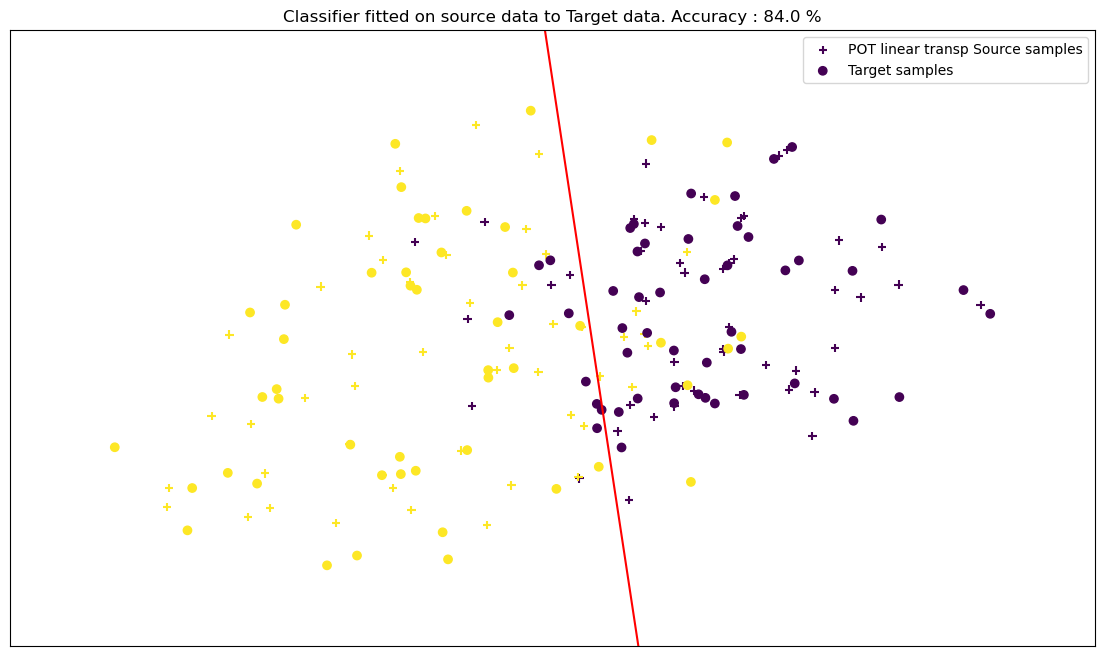

In [ ]:
# We fit a new svm model on the transported data
(
    svm_model_StoT_linear,
    x_points_StoT_linear,
    y_points_StoT_linear,
    acc_StoT_linear,
) = SVM_classifier(X=transp_Xs_linear, y=y_s, target_x=x_t, target_y=y_t)

plotter(
    transp_Xs_linear,
    "POT linear transp Source samples",
    svm_model_StoT_linear,
    x_points_StoT_linear,
    y_points_StoT_linear,
    acc_StoT_linear,
)

Accuracy: 0.8


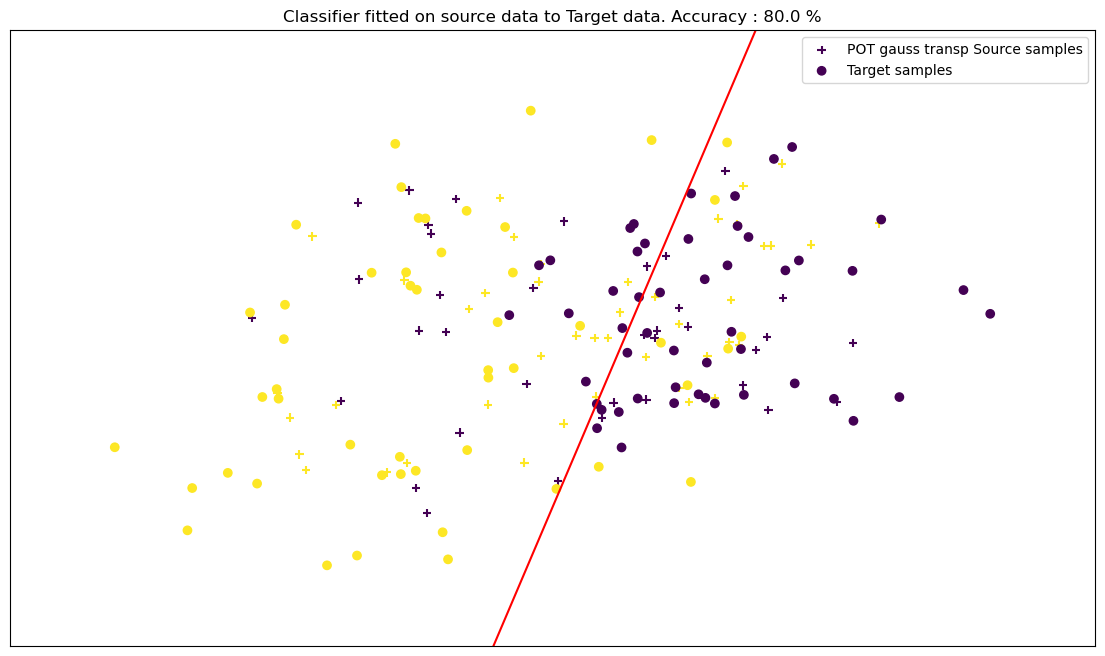

In [ ]:
(
    svm_model_StoT_gauss,
    x_points_StoT_gauss,
    y_points_StoT_gauss,
    acc_StoT_gauss,
) = SVM_classifier(X=transp_Xs_gaussian, y=y_s, target_x=x_t, target_y=y_t)

plotter(
    transp_Xs_gaussian,
    "POT gauss transp Source samples",
    svm_model_StoT_gauss,
    x_points_StoT_gauss,
    y_points_StoT_gauss,
    acc_StoT_gauss,
)

The accuracy with the gaussian kernel is bad compared to the other two. It may be due to poor hyper parameter tuning and the fact that the domain drift is linear here.

# Speed test

In [ ]:
import timeit

OTT-JAX is a recent python package, which seeks to improve the computation speed of OT algorithms, let's test it against POT. You can play with repeats and number to have a more accurate result.

In [ ]:
for n in [10, 100, 1_000, 10_000]:
    setup_ottjax = f"""from ott.geometry import pointcloud,costs
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from __main__ import make_classification_domain_drift


x_s,y_s,x_t,y_t = make_classification_domain_drift(n={n},
                                                  noise_level= 0.05,
                                                  drift_intensity_mean = 3,
                                                  drift_intensity_var = 1.5,
                                                  numpy_output = False
                                                  )

"""

    code_ottjax = """geom = pointcloud.PointCloud(x_s, x_t)
ot_prob = linear_problem.LinearProblem(geom)

solver = sinkhorn.Sinkhorn()

ot = solver(ot_prob)
dual_potentials = ot.to_dual_potentials()
transp_x_s = dual_potentials.transport(x_s)
"""

    t = min(timeit.repeat(code_ottjax, setup=setup_ottjax, repeat=1, number=1))

    print(f"{n} : {t}")

10 : 1.0422309169953223
100 : 0.01747179200174287
1000 : 1.4145388329925481
10000 : 13.158143790991744


We'll only consider the case of the linear kernel

In [ ]:
for n in [10, 100, 1_000]:
    setup_pot = f"""import ot as pot
from __main__ import make_classification_domain_drift
x_s,y_s,x_t,y_t = make_classification_domain_drift(n={n},
                                                   noise_level= 0.05,
                                                   drift_intensity_mean = 3,
                                                   drift_intensity_var = 1.5,
                                                   numpy_output = True
                                                   )

"""

    code_pot = """ot_mapping_linear = pot.da.MappingTransport(
    kernel="linear", mu=1e0, eta=1e-8, bias=True,
    max_iter=1000)

ot_mapping_linear.fit(Xs=x_s, Xt=x_t)

transp_Xs_linear = ot_mapping_linear.transform(Xs=x_s)

"""
    t = min(timeit.repeat(code_pot, setup=setup_pot, repeat=1, number=1))

    print(f"{n} : {t}")

10 : 0.0035730829986277968
100 : 0.07637645900831558
1000 : 5.691310499998508


We can see that OTT-JAX package is faster than POT package. We took the very easy case where the domain drift is linear but it could change if we add lot of dimension and complicity. 

## Conclusion

Throughout this notebook, we have delved into the Domain Adaptation problem and its impact on Machine Learning models. We demonstrated the challenges faced when models trained on one domain must be adapted to a different domain with varying distributions. Optimal Transport theory, as proposed by Genevay, Peyré, and Cuturi, has been shown to be an effective solution for this problem.

We implemented an Optimal Transport-based approach using the ott-Jax package, which allowed us to align the source and target domain distributions by minimizing the distance between them. As a result, we improved the model's performance on the target domain. We also compared the ott-Jax package with the POT package to analyze the convergence of the OT method and the computational cost associated with each package.

Furthermore, we introduced a binary classification problem with an artificial domain drift to illustrate the robustness of our approach. We first applied a SVM classifier to highlight the performance issues caused by the domain drift. Then, we utilized Optimal Transport with both the ott-Jax and POT packages to align the source and target distributions, leading to an improved classifier performance on the target domain. We saw that the OTT-Jac Optimal transport for linear solving gets best performance for the final classifier than the POT package, it may cause by the overtunning and the default parameter of each package. 

In conclusion, Optimal Transport theory presents a promising approach to tackling the Domain Adaptation problem. It enables the development of more versatile Machine Learning models that can adapt to varying distributions, ultimately improving their performance and applicability in real-world scenarios.
